# 1. Compute the camera calibration using the chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as im
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

class Camera(object):
    def __init__(self):
        self.mtx  = None
        self.dist = None

    def calibrate(self, imagesPath):
        """
            Calibrate camera using set of images
        Args:
            imagesPath(string)  - path to input images
        Returns:
            None
        """
        
        # Object points
        objp = np.zeros((6 * 9, 3), np.float32)
        objp[:, :2] = np.mgrid[0 : 9, 0 : 6].T.reshape(-1, 2)

        objpoints = []
        imgpoints = []

        images = glob.glob(imagesPath)

        for idx, filename in enumerate(images):
            # Read image
            image = im.imread(filename)
            # Convert to gray scale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            # Find image points
            isFound, points = cv2.findChessboardCorners(gray, (9, 6), None)
            # Check if we found an image
            if isFound == True:
                objpoints.append(objp)
                imgpoints.append(points)

        # Read test image
        image = im.imread(images[0])
        size  = (image.shape[1], image.shape[0])

        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)

        self.mtx  = mtx
        self.dist = dist
    
    def  undistort(self, image):
        """
            Undistort image
        Args:
            image(np.array)  - (width x height x channel) distorted image. 
        Returns:
            undistort image
        """
        
        if self.mtx is None or self.dist is None:
            raise Exception("You need to calibrate the camera first")

        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)

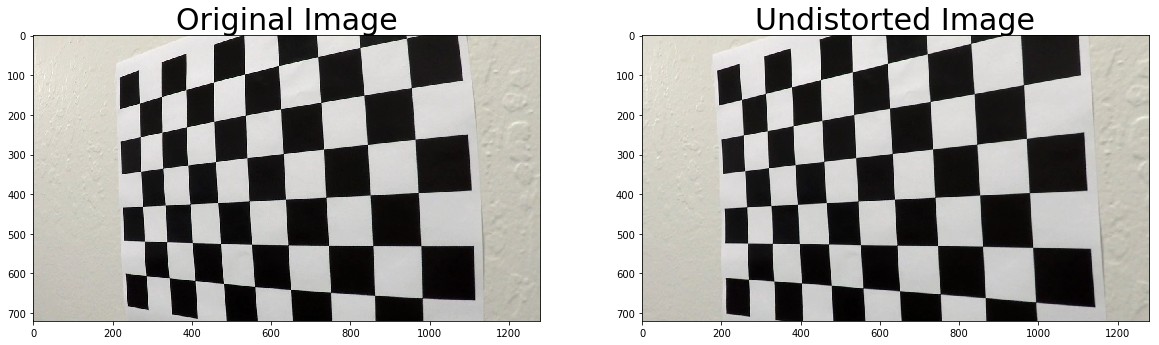

In [2]:
camera = Camera()

camera.calibrate("./camera_cal/*.jpg")

# Read test image
image = im.imread("camera_cal/calibration4.jpg")
dst   = camera.undistort(image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# 2. Undistort raw image

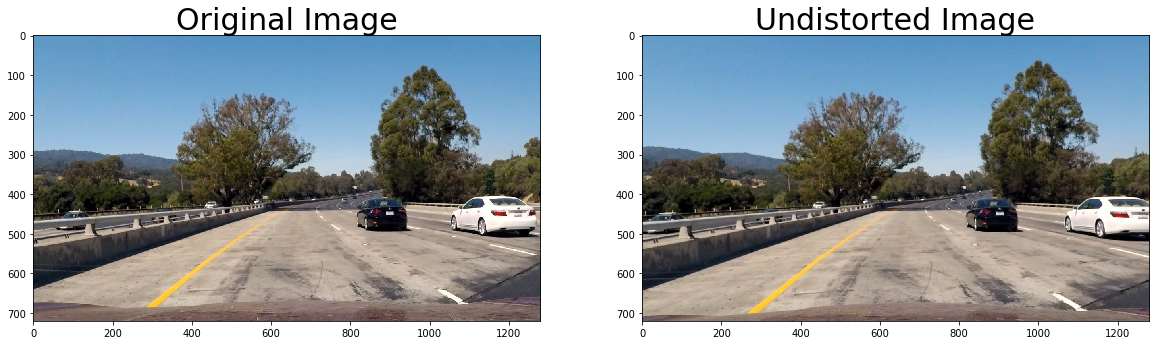

In [3]:
image = plt.imread("test_images/test1.jpg")
undistorted_image = camera.undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize = 30)

# 3. Apply colour transformation to create a thresholded binary image

In [4]:
def channel_threshold(channel, min=0, max=255):
    """
         convert single channel to binray image using 
         a given range.
        Args:
            channel(np.array) - (heigt x width) matrix represnt single channel.
            min(int)          - Thrshold lower bound
            max(int)          - Thrshold upper bound
        Returns:
            A (height x Width) array which respreset binray mask 
            for single channel
    """ 

    binary = np.zeros_like(channel).astype(np.uint8) 
    binary[(channel >= min) & (channel <= max)] = 1
    return binary

def color_threshold(image, min, max):
    """
         convert image to binray image using 
         a given range.
        Args:
            image(np.array)   - (heigt x width x channels) matrix represnt an colored image.
            min(int)          - Thrshold lower bound
            max(int)          - Thrshold upper bound
        Returns:
            A (height x Width x 1) array which respreset binray mask 
            for an image
    """ 
    c1_mask = channel_threshold(image[:,:,0], min=min[0], max=max[0])
    c2_mask = channel_threshold(image[:,:,1], min=min[1], max=max[1])
    c3_mask = channel_threshold(image[:,:,2], min=min[2], max=max[2])
    binary = np.zeros_like(c1_mask)
    binary[(c1_mask == 1) & (c2_mask==1) & (c3_mask==1)] = 1
    return binary


def binary_mask(image):
    """
        Use color threash hold using HSV/LUV color space to
        create mask for the white and yellow lines.
        Args:
            image(np.array) - (heigt x width x channels) matrix represnt an colored image.
        Returns:
            A (height x Width x 1) array which respreset binray image with 
            white and yellow lines marked.
    """ 
    hsv   = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    luv   = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    yellow_mask = color_threshold(hsv, [0,80,200],[255,255,255])
    white_mask  = color_threshold(hsv, [0,0,218],[255,255,255])
    luv_mask    = color_threshold(luv, [215,95,140], [254,106,148])
    
    combined_binary = np.zeros_like(yellow_mask)
    combined_binary[(yellow_mask == 1) | (white_mask == 1) | (luv_mask==1)] = 1
    return combined_binary

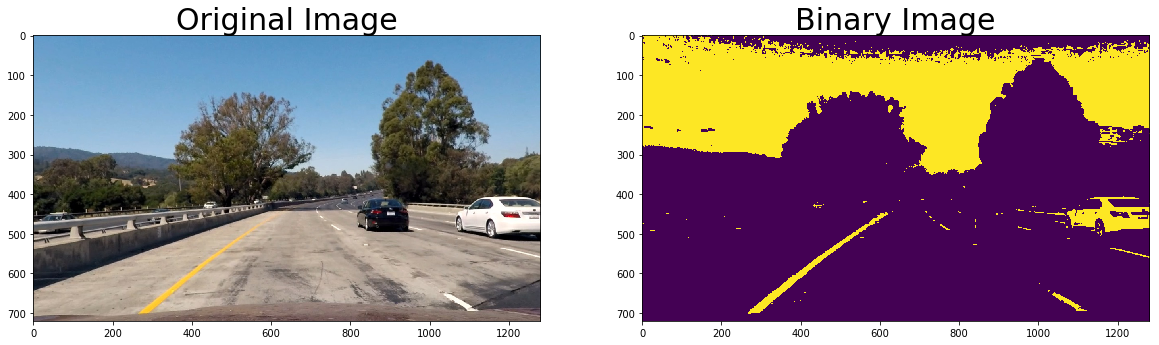

In [5]:
binary = binary_mask(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary)
ax2.set_title('Binary Image', fontsize=30)

# 4. Apply the perspective transform to get a birds eye view

In [6]:
def get_perspective_transform(image, src, dst):
    """
        Conpute the perspective transform matrix
        using source and destination points
        Args:
            image(np.array)   - (heigt x width x channels) matrix represnt an colored image.
            src(np.array)     - array hold list of points  from source image
            dst(int)          - array hold list of points  from destination image (warped)
        Returns:
            Perspective transform matrix and the inverse
    """ 
    image_size    = (image.shape[1], image.shape[0])
  
    M    = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

def warp(binary, M):
    """
        Transform an image to brid view.
        Args:
            image(np.array)   - (heigt x width x channels) matrix represnt an colored image.
            M(np.array)       - Transform matrix.
        Returns:
             Transformed image.
    """ 
    image_size    = (binary.shape[1], binary.shape[0])
    return cv2.warpPerspective(binary, M, image_size, flags=cv2.INTER_LINEAR)

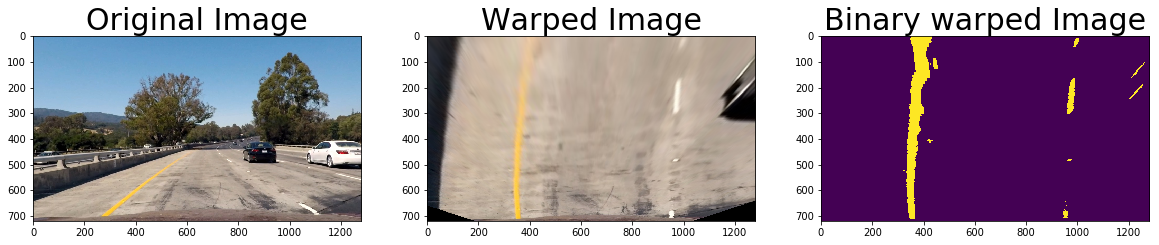

In [7]:
src        = np.float32([[(200, 720), (570, 465), (730, 465), (1200, 720)]]) 
dst        = np.float32([[(320, 720), (320, 0), (980, 0), (980, 720)]])
M, Minv    = get_perspective_transform(image, src, dst)

warped        = warp(undistorted_image, M)
binary_warped = warp(binary, M)

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
ax3.imshow(binary_warped)
ax3.set_title('Binary warped Image', fontsize=30)

# 5. Detect lane pixels and find the lane boundary

In [8]:
# Global variable
ym_per_pix = 20/720
xm_per_pix = 3.7/700

def find_lines(image, nwindows=9):
    """
            Search for left and right lines using sliding windows
        Args:
            image(np.array)    - (heigt x width x 1) matrix represnt binray image.
            nwindows(int)      - number of search windows.
        Returns:
            fitting for left and right lanes along with x,y coordinates for
            the discovred points.
    """
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

    # Find left and right peak
    midpoint = np.int(histogram.shape[0]/2) # Mid point
    left_base= np.argmax(histogram[:midpoint])
    right_base= np.argmax(histogram[midpoint:]) + midpoint

    # Height of window
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x, y points of all . onseros pixls
    nonzero  = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions of all none zeros pixels
    left_current  = left_base
    right_current = right_base
    # Set width of window +/- margin
    margin = 60
    # set number of pixels found to recenter window
    minpix = 50

    left_lane_inds  = []
    right_lane_inds = []

    for window in range(nwindows):
        # identify window boundaries x/y and Left/Right
        win_y_low       = image.shape[0] - (window+1)*window_height
        win_y_high      = image.shape[0] - window*window_height
        win_xleft_low   = left_current - margin
        win_xleft_high  = left_current + margin
        win_xright_low  = right_current - margin
        win_xright_high = right_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                                                     (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append new indices
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current= np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit= np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

def draw_polyline(img, fit):
    """
            Draw second degree polynomial line on an image
        Args:
            binary_warped(np.array)   - (heigt x width x channels) matrix represnt image.
            fit(np.array)             - Second degree polynomial.
        Returns:
            True if the left and right fit should be accepted otherwise False.
    """
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    pts = np.array([np.transpose(np.vstack([x, y]))])
    cv2.polylines(img, np.int_(pts), isClosed=False, color=(255,255,0), thickness=3)
    return img

def draw_fit(binary_image, leftx, lefty,rightx,righty,left_fit, right_fit, margin=60):
    """
            Draw second degree polynomial line and swarxh window on an image
        Args:
            binary_warped(np.array)   - (heigt x width x channels) matrix represnt image.
            lefty(np.array)           - list of y coordinates for detected points in the
                                        left line.
            leftx(np.array)           - list of x coordinates for detected points in the
                                        left line.
            righty(np.array)          - list of y coordinates for detected points in the
                                        right line.
            rightx(np.array)          - list of x coordinates for detected points in the
                                        right line.
            left_fit(np.array)        - Second degree polynomial for left line.
            right_fit(np.array)       - Second degree polynomial for right line.
            margin(int)               - Width for the search window.
        Returns:
            Image which shows the lines and detected points.
    """
    y = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
   
    left_fitx  = left_fit[0] * y**2+left_fit[1]*y+left_fit[2]
    right_fitx = right_fit[0] * y**2+right_fit[1]*y+right_fit[2]

    # Create output image
    out_image = np.dstack((binary_image, binary_image, binary_image))*255
    window_img = np.zeros_like(out_image)
    
    out_image[lefty,  leftx]  = [255,0,0]
    out_image[righty, rightx] = [0,0,255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, y]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  y])))])

    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, y]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  y])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_image, 1, window_img, 0.3, 0)
    
    draw_polyline(result, left_fit)
    draw_polyline(result, right_fit)

    return result

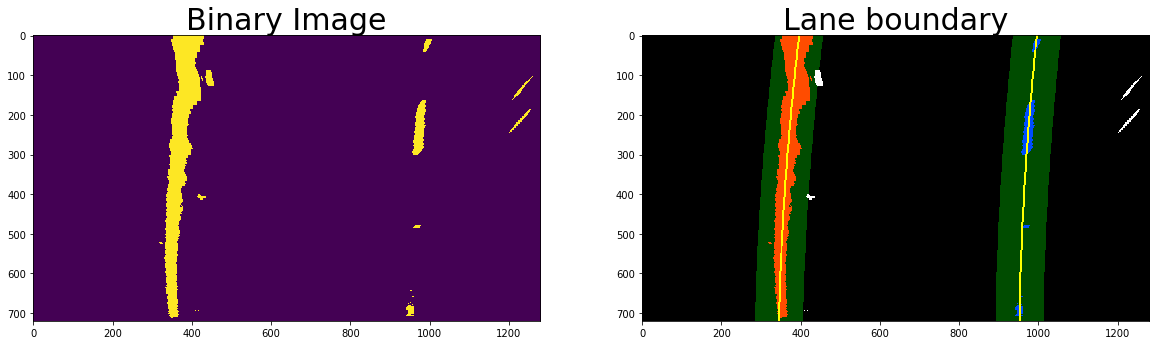

In [9]:
left_fit, right_fit, leftx, lefty, rightx, righty = find_lines(binary_warped)
lane_boundary = draw_fit(binary_warped, leftx, lefty, rightx, righty, left_fit, right_fit, margin=60)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped)
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(lane_boundary)
ax2.set_title('Lane boundary', fontsize=30)

# 6. Calculate the curvature of the lane and the car position with respec to center

In [10]:
def compute_curvature_and_distance(image, y, left_fit, right_fit):
    """
            Draw second degree polynomial line and swarxh window on an image
        Args:
            image(np.array)           - (heigt x width x 1) matrix represnt image.
            left_fit(np.array)        - Second degree polynomial for left line.
            right_fit(np.array)       - Second degree polynomial for right line.
        Returns:
            curvature and distance from center.
    """
    y      = np.linspace(0, image.shape[0]-1, image.shape[0])
    leftx  = left_fit[0]  * y**2 + left_fit[1]  * y + left_fit[2]
    rightx = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
    y_eval = np.max(y)
    height = image.shape[0] # Image height

    # Compute curvatures
    left_fit_cr  = np.polyfit(y*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Compute curvature
    curvature = (left_curvature + right_curvature) / 2


    # Distance from the center
    car_center  = image.shape[1] / 2  # Computer center of the car
    xleft       = left_fit[0]*height**2  + left_fit[1]*height  + left_fit[2]
    xright      = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    lane_center = (xleft + xright)/2 # Compute the center of the lane
    distance    = (car_center - lane_center) * xm_per_pix # Convert from pxiels to meters

    return curvature, distance

In [11]:
y = np.linspace(0, image.shape[0]-1, image.shape[0])
curvature, distance = compute_curvature_and_distance(undistorted_image, y, left_fit, right_fit)

curvature_text = "Radius of curvature : {0:0.2f}m ".format(curvature) 
distance_text  = "Vehicle is {0:0.3f}m {1} of the center".format(abs(distance),
                                                                "Right" if distance > 0 else "Left")

print(curvature_text)
print(distance_text)

Radius of curvature : 1200.52m 
Vehicle is 0.041m Left of the center


# 7. Warp the lane boundary back onto the raw image

In [12]:
def mark_lane(image, binary_warped, left_fit, right_fit, Minv):
    """
            Draw the lane  in the output image image
        Args:
            image(np.array)           - (heigt x width x channels) matrix represnt orignal image.
            binary_warped(np.array)   - (heigt x width x 1) matrix represnt image.
            left_fit(np.array)        - Second degree polynomial for left line.
            right_fit(np.array)       - Second degree polynomial for right line.
            Minv(p.array)             - Inverse transformation matrix.
        Returns:
            Final output image with lane marked and .
    """
    # Fit polynomial for the left and right lines 
    y      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    xleft  = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    xright = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
  
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left  = np.array([np.transpose(np.vstack([xleft, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([xright, y])))])
    pts       = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_image =  cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return marked_image

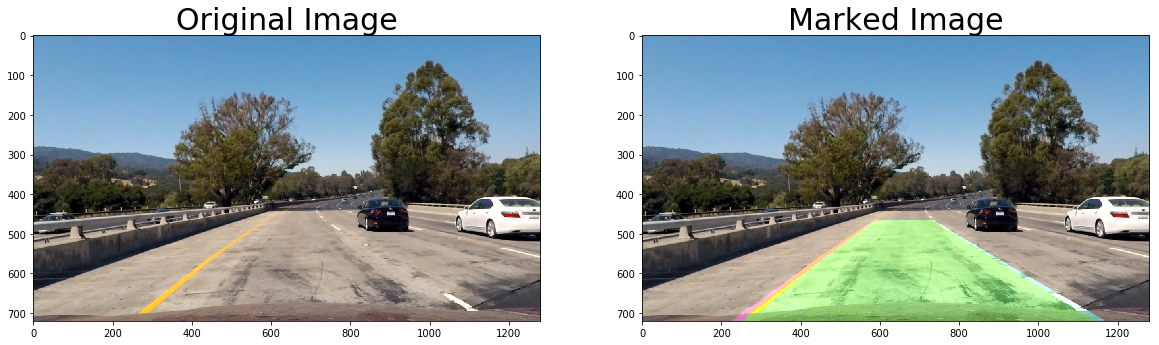

In [13]:
marked_image = mark_lane(undistorted_image, binary_warped, left_fit, right_fit,  Minv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(marked_image)
ax2.set_title('Marked Image', fontsize=30)

# 8. Draw the radius of curvature and car position to the mared image

In [14]:
def draw_curvatures_and_distance(image, left_fit, right_fit):
    """
            Draw curvature and distance on the output image
        Args:
            image(np.array)           - (heigt x width x channels) matrix represnt colored image.
            left_fit(np.array)        - Second degree polynomial for left line.
            right_fit(np.array)       - Second degree polynomial for right line.
        Returns:
            Image which shows the curvature and distance,
    """
    y = np.linspace(0, image.shape[0]-1, image.shape[0])

    # Calculate curvatures and distance
    curvature, distance = compute_curvature_and_distance(image, y, left_fit, right_fit)

    # Font and color
    font  = cv2.FONT_HERSHEY_DUPLEX
    color = (255,255,255)

    curvature_text = "Radius of curvature : {0:0.2f}m ".format(curvature) 
    distance_text  = "Vehicle is {0:0.3f}m {1} of the center".format(abs(distance),
                                                                         "Right" if distance > 0 else "Left")

    cv2.putText(image, curvature_text, (20,60),  font, 1.5, color, 2, cv2.LINE_AA)
    cv2.putText(image, distance_text,  (20,110), font, 1.5, color, 2, cv2.LINE_AA)

    return image

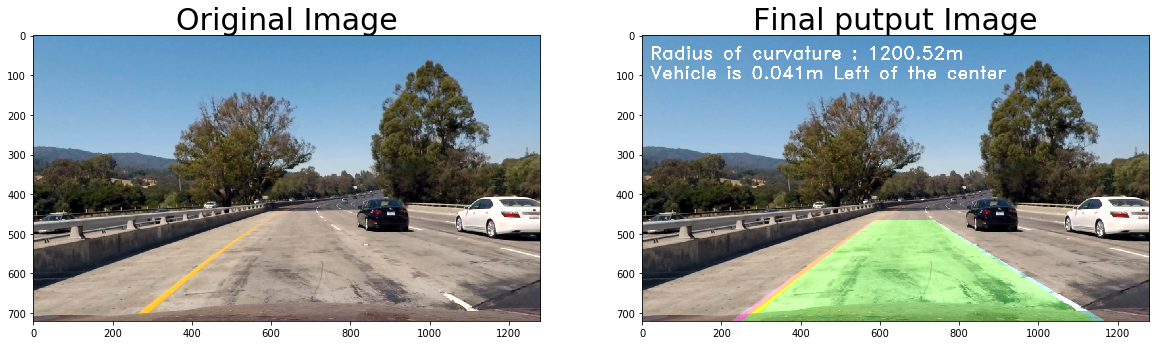

In [15]:
output = draw_curvatures_and_distance(marked_image, left_fit, right_fit)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(marked_image)
ax2.set_title('Final putput Image', fontsize=30)

# 9. Execute the pipeline

In [16]:
def find_lane_using_previous_fit(image, current_left_fit, current_right_fit, margin = 60):
    """
            Search for left and right lines based on last valid fitted second degree polynomials
        Args:
            image(np.array)            - (heigt x width x channels) matrix represnt orignal image.
            binary_warped(np.array)     - (heigt x width x 1) matrix represnt image.
            current_left_fit(np.array)  - The last valid Second degree polynomial for left line.
            current_right_fit(np.array) - The last valid Second degree polynomial for right line.
            margin(p.array)             - width of the search window.
        Returns:
            fitting for left and right lanes along with x,y coordinates for
            the discovred points.
    """
    nonzero = image.nonzero()
    y       = np.array(nonzero[0])
    x       = np.array(nonzero[1])
    

    left_lane_inds = ((x > (current_left_fit[0]*(y**2) + current_left_fit[1]*y +  current_left_fit[2] - margin)) & 
                      (x < (current_left_fit[0]*(y**2) + current_left_fit[1]*y + current_left_fit[2] + margin))) 

    right_lane_inds = ((x > (current_right_fit[0]*(y**2) + current_right_fit[1]*y + current_right_fit[2] - margin)) & 
                       (x < (current_right_fit[0]*(y**2) + current_right_fit[1]*y + current_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = x[left_lane_inds]
    lefty = y[left_lane_inds] 
    rightx = x[right_lane_inds]
    righty = y[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [17]:
class LanesDetector(object):
    def __init__(self, camera):
        self.nframes        = 5
        self.camera         = camera
        self.M              = None
        self.Minv           = None
        self.src            = np.float32([[(200, 720), (570, 465), (730, 465), (1200, 720)]]) 
        self.dst            = np.float32([[(320, 720), (320, 0), (980, 0), (980, 720)]])
        #Avarage Fit
        self.detected       = False
        self.left_best_fit  = None
        self.right_best_fit = None
        # Hold  last n fits 
        self.left_current_fit  =  []
        self.right_current_fit = []

    
    
    def sanity_check(self, binary_warped, left_fit, right_fit):
        """
            Check if the Second degree polynomial for left  and rightlines
            should be accepted.
        Args:
            binary_warped(np.array)   - (heigt x width x channels) matrix represnt binary warped image.
            left_fit(np.array)        - Second degree polynomial for left line.
            right_fit(np.array)       - Second degree polynomial for right line.
        Returns:
            True if the left and right fit should be accepted otherwise False.
        """ 
        if left_fit is None or right_fit is None:
            # No lane detected.
            return False
        
        # 1. Conpute distence betweem left and right points
        y      = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        leftx  = left_fit[0] * y**2  + left_fit[1] * y  + left_fit[2]
        rightx = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
        diff   = rightx - leftx
        
        # 2. Compute the STD for distance between the points 
        std    = np.std(diff)
    
        # 3. only accept lane with STD < 40 given the
        #    the distance between left and right points
        #    greater then zero 
        return (std < 40 and np.all(diff > 0))

    def mark_lane(self, image):
        """
            Detect and mark the lanes
        Args:
            image(np.array)   - (heigt x width x channels) matrix represnt colored image.
        Returns:
            (heigt x width x channels) matrix represnt colored image with lane marked.            
        """ 
        # Calculate matrix transformation
        if self.M is None:
            self.M, self.Minv  = get_perspective_transform(image, self.src, self.dst)
            
        # 1. undistort image
        undistorted_image = self.camera.undistort(image)

        # 2. Create binary mask using color thresholding
        binary = binary_mask(undistorted_image)

        # 3. warp
        binary_warped = warp(binary, self.M)

        # 4. Find lane
        if self.detected:
            left_fit, right_fit, leftx, lefty, rightx, righty = find_lane_using_previous_fit(binary_warped, 
                                                                                             self.left_current_fit[-1], 
                                                                                             self.right_current_fit[-1])
        else:
            left_fit, right_fit, leftx, lefty, rightx, righty = find_lines(binary_warped)
       
       # 5. Check the new fitted lines
        if self.sanity_check(binary_warped,left_fit,right_fit):
            # Mark lane is detevcted and and left abd right fits to
            # the current list
            self.detected = True
            self.left_current_fit.append(left_fit)
            self.right_current_fit.append(right_fit)
            
            # Only keep n frames
            if len(self.left_current_fit) > self.nframes:
                self.left_current_fit  = self.left_current_fit[1:]
                self.right_current_fit = self.right_current_fit[1:]
            # Compute the mean
            self.left_best_fit = np.mean(self.left_current_fit, axis=0)
            self.right_best_fit = np.mean(self.right_current_fit, axis=0)
        elif self.left_best_fit is None:
            # We don't have fit, rturn the same image
            return image

        # 5. Mark lane
        marked_image =  mark_lane(undistorted_image, binary_warped, 
                                  self.left_best_fit, self.right_best_fit, 
                                  self.Minv)
        # 6. Compute the curvature and distance with respect to center 
        return draw_curvatures_and_distance(marked_image, self.left_best_fit, self.right_best_fit)

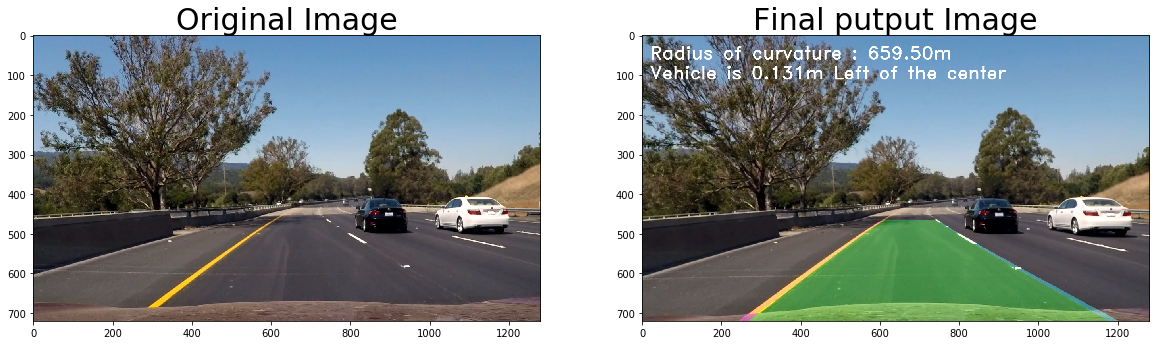

In [ ]:
image    = plt.imread("./test_images/test6.jpg")
detector = LanesDetector(camera)
output   = detector.mark_lane(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output)
ax2.set_title('Final putput Image', fontsize=30)

# 10. Process the video

In [ ]:
detector = LanesDetector(camera)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(lambda image: detector.mark_lane(image))
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 83%|████████▎ | 1051/1261 [01:25<00:18, 11.35it/s]

In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))